In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels

In [2]:
import urllib
params ='DRIVER={SQL Server};SERVER=CL-AMILAH\AMILA;DATABASE=GSH;UID=Amila;Trusted_Connection=yes;'       
params = urllib.parse.quote_plus(params)

from sqlalchemy import create_engine
db = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)

In [3]:
sql = '''
SELECT inv.[ID] ,inv.SiteUID, [Date] , [OutletUID] ,ot.Name AS outlet ,ot.ProvinceUID,pr.Description AS province ,ot.DistrictUID ,  di.Description AS district 
, ot.AreaUID , ar.Description AS Area , inv.[AgentUID] ,Concat(emp.FirstName ,' ' , emp.MiddleInitials , ' ', emp.LastName ) AS AgentName , inv.[DistributorUID] , d.Name AS distributor, [ItemUID] ,it.Description AS item, [UnitQty] 
, [UnitPrice] , [RetailUnitPrice] , [FreeQty] , [FreeCompanyQty] , [GrossValue]
,datename(YEAR, Date) AS Year
,datename(month, Date) AS MonthName
,MONTH(Date) AS Month
,datename(DAY, Date) AS Day
,DATEPART(DW,Date) AS WeekDay
,datename(WEEKDAY, Date) AS DateName
,DATEPART (hh,Date) as Hour

  FROM [GSH].[dbo].[vw_Invoice] inv
  LEFT JOIN [GSH].[dbo].[vw_InvoiceLine] invl
  ON inv.siteUID = invl.TxnInvoice_SiteUID AND inv.uid = invl.TxnInvoiceUID	
  LEFT JOIN [GSH].[dbo].[Item] it
  ON invl.ItemUID = it.UID
  LEFT JOIN [GSH].[dbo].[Outlet] ot
  ON inv.OutletUID = ot.UID
  LEFT JOIN [GSH].[dbo].[Area] pr
  ON ot.ProvinceUID = pr.UID
  LEFT JOIN [GSH].[dbo].[Area] di
  ON ot.DistrictUID = di.UID
  LEFT JOIN [GSH].[dbo].[Area] ar
  ON ot.AreaUID = ar.UID
  LEFT JOIN [GSH].[dbo].[Distributor] d
  ON inv.DistributorUID = d.UID
  LEFT JOIN [GSH].[dbo].[avLogin] avlg
  ON inv.AgentUID = avlg.BusinessUserUID
  LEFT JOIN [GSH].[dbo].[Employee] emp
  ON avlg.EmployeeUID = emp.UID
  WHERE inv.mpt_TypeEnum IN ( 21 , 44, 14, 1) AND inv.ExpiryDate IS NULL AND inv.SubmittedDate IS NOT NULL
  AND Date >= '2018-11-01' AND Date <= '2020-03-01' ;
'''

invoice_All = pd.read_sql_query(sql, db)

In [4]:
#disply all the columns
pd.set_option('display.max_columns', None)

In [5]:
 #get date from date time
invoice_All['just_date'] = invoice_All['Date'].dt.date

In [6]:
invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,ProvinceUID,province,DistrictUID,district,AreaUID,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour,just_date
0,CSO007901612,53,2018-11-07 08:00:34.380,373,SUWANA HOSPITAL,24.0,North Western Province,26.0,Puttalam,92.0,CHILAW,79,Sumedha Nilanka,2,The West Central Pharma (Pvt) Ltd.,335,Enervon Hp Choco. 400gm,3.0,1667.0,1850.0,0.0,0.0,5001.0,2018,November,11,7,4,Wednesday,8,2018-11-07
1,CSO007901615,53,2018-11-07 08:04:21.617,386,ROYAL PHARMACY 2,24.0,North Western Province,26.0,Puttalam,92.0,CHILAW,79,Sumedha Nilanka,2,The West Central Pharma (Pvt) Ltd.,26,Flanil Cream 30gm,10.0,165.0,188.0,0.0,0.0,1650.0,2018,November,11,7,4,Wednesday,8,2018-11-07
2,CSO007901615,53,2018-11-07 08:04:21.617,386,ROYAL PHARMACY 2,24.0,North Western Province,26.0,Puttalam,92.0,CHILAW,79,Sumedha Nilanka,2,The West Central Pharma (Pvt) Ltd.,26,Flanil Cream 30gm,0.0,165.0,188.0,3.0,3.0,0.0,2018,November,11,7,4,Wednesday,8,2018-11-07
3,CSO007901612,53,2018-11-07 08:00:34.380,373,SUWANA HOSPITAL,24.0,North Western Province,26.0,Puttalam,92.0,CHILAW,79,Sumedha Nilanka,2,The West Central Pharma (Pvt) Ltd.,205,Solmux P. Susp 60ml,6.0,377.2,430.0,0.0,0.0,2263.2,2018,November,11,7,4,Wednesday,8,2018-11-07
4,CSO007901615,53,2018-11-07 08:04:21.617,386,ROYAL PHARMACY 2,24.0,North Western Province,26.0,Puttalam,92.0,CHILAW,79,Sumedha Nilanka,2,The West Central Pharma (Pvt) Ltd.,21,Fludan Caps 5mg 100's,1.0,2785.0,3175.0,0.0,0.0,2785.0,2018,November,11,7,4,Wednesday,8,2018-11-07


### Select the most selling product to identify the time series prediction

In [7]:
# select product sales records 
#Losatrust 50mg top 2 product
Sec_invoices = invoice_All.loc[invoice_All['ItemUID'] == 43]

In [8]:
Sec_invoices

,ID,SiteUID,Date,OutletUID,outlet,ProvinceUID,province,DistrictUID,district,AreaUID,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour,just_date
200,CSO011701378,54,2018-11-02 07:57:45.397,372,HEALTHY CARE PHARMACY,24.0,North Western Province,26.0,Puttalam,92.0,CHILAW,117,,2,The West Central Pharma (Pvt) Ltd.,43,Losatrust 50mg 100's,50.0,276.3,315.0,0.0,0.0,13815.0,2018,November,11,2,6,Friday,7,2018-11-02
201,CSO011701378,54,2018-11-02 07:57:45.397,372,HEALTHY CARE PHARMACY,24.0,North Western Province,26.0,Puttalam,92.0,CHILAW,117,,2,The West Central Pharma (Pvt) Ltd.,43,Losatrust 50mg 100's,0.0,276.3,315.0,10.0,10.0,0.0,2018,November,11,2,6,Friday,7,2018-11-02
331,IN0066000103,0,2018-11-02 12:05:39.753,2693,Sethsuwa Pharmacy,16.0,Southern Province,19.0,Hambantota,382.0,Angunukolapelessa,155,Priyashantha Niyagamage,14,Unichemist Distributor,43,Losatrust 50mg 100's,3.0,276.3,315.0,0.0,0.0,828.9,2018,November,11,2,6,Friday,12,2018-11-02
450,IN0065000284,0,2018-11-02 09:07:00.637,4326,Ntv Pharmacy,2.0,Central Province,5.0,Nuwara Eliya,370.0,Nuwara Eliya,101,Asanga Peiris,13,Prabaharan Agencies,43,Losatrust 50mg 100's,25.0,276.3,315.0,0.0,0.0,6907.5,2018,November,11,2,6,Friday,9,2018-11-02
451,IN0065000284,0,2018-11-02 09:07:00.637,4326,Ntv Pharmacy,2.0,Central Province,5.0,Nuwara Eliya,370.0,Nuwara Eliya,101,Asanga Peiris,13,Prabaharan Agencies,43,Losatrust 50mg 100's,0.0,276.3,315.0,3.0,3.0,0.0,2018,November,11,2,6,Friday,9,2018-11-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953940,CSO008504928,502,2020-01-25 12:50:56.587,1342,Rambukkenna Pharmacy,33.0,Sabaragamuwa Province,35.0,Kegalle,213.0,Rambukkana,85,Chandana Gunasingha,6,J.G.P Marketing (Pvt) Ltd,43,Losatrust 50mg 100's,0.0,313.0,360.0,3.0,3.0,0.0,2020,January,1,25,7,Saturday,12,2020-01-25
953941,CSO008504966,502,2020-01-29 13:09:55.740,1345,Kandy Medical,33.0,Sabaragamuwa Province,35.0,Kegalle,206.0,Mawanella,85,Chandana Gunasingha,6,J.G.P Marketing (Pvt) Ltd,43,Losatrust 50mg 100's,10.0,313.0,360.0,0.0,0.0,3130.0,2020,January,1,29,4,Wednesday,13,2020-01-29
953942,CSO008504966,502,2020-01-29 13:09:55.740,1345,Kandy Medical,33.0,Sabaragamuwa Province,35.0,Kegalle,206.0,Mawanella,85,Chandana Gunasingha,6,J.G.P Marketing (Pvt) Ltd,43,Losatrust 50mg 100's,0.0,313.0,360.0,1.0,1.0,0.0,2020,January,1,29,4,Wednesday,13,2020-01-29
953946,CSO008505024,502,2020-02-06 10:42:51.047,1298,Mecaw Phramacy,2.0,Central Province,4.0,Matale,205.0,Matale,85,Chandana Gunasingha,6,J.G.P Marketing (Pvt) Ltd,43,Losatrust 50mg 100's,10.0,313.0,360.0,0.0,0.0,3130.0,2020,February,2,6,5,Thursday,10,2020-02-06


In [9]:
#group data by invoice
Sec_invoices_Agg = Sec_invoices.groupby("ID").agg({'GrossValue':'sum' , 'just_date' : 'max'}).reset_index()

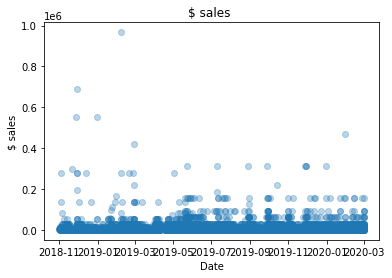

In [10]:
plt.scatter(Sec_invoices_Agg.just_date , Sec_invoices_Agg.GrossValue , alpha=0.3,cmap='viridis')
plt.xlabel("Date")
plt.ylabel("$ sales")
plt.title("$ sales ")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

In [11]:
# remove z score > 3 
Selc_Inv_No_Otlr = Sec_invoices_Agg[(np.abs(stats.zscore(Sec_invoices_Agg["GrossValue"])) < 3)]

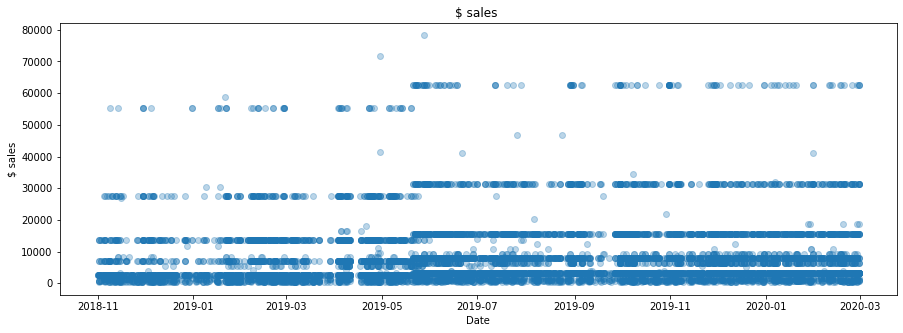

In [12]:
plt.scatter(Selc_Inv_No_Otlr.just_date , Selc_Inv_No_Otlr.GrossValue , alpha=0.3,cmap='viridis')
plt.xlabel("Date")
plt.ylabel("$ sales")
plt.title("$ sales ")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

In [13]:
Sel_Inv_no_out_All = Sec_invoices[Sec_invoices['ID'].isin(Selc_Inv_No_Otlr.ID)]

In [14]:
Sel_Inv_no_out_All

,ID,SiteUID,Date,OutletUID,outlet,ProvinceUID,province,DistrictUID,district,AreaUID,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour,just_date
200,CSO011701378,54,2018-11-02 07:57:45.397,372,HEALTHY CARE PHARMACY,24.0,North Western Province,26.0,Puttalam,92.0,CHILAW,117,,2,The West Central Pharma (Pvt) Ltd.,43,Losatrust 50mg 100's,50.0,276.3,315.0,0.0,0.0,13815.0,2018,November,11,2,6,Friday,7,2018-11-02
201,CSO011701378,54,2018-11-02 07:57:45.397,372,HEALTHY CARE PHARMACY,24.0,North Western Province,26.0,Puttalam,92.0,CHILAW,117,,2,The West Central Pharma (Pvt) Ltd.,43,Losatrust 50mg 100's,0.0,276.3,315.0,10.0,10.0,0.0,2018,November,11,2,6,Friday,7,2018-11-02
331,IN0066000103,0,2018-11-02 12:05:39.753,2693,Sethsuwa Pharmacy,16.0,Southern Province,19.0,Hambantota,382.0,Angunukolapelessa,155,Priyashantha Niyagamage,14,Unichemist Distributor,43,Losatrust 50mg 100's,3.0,276.3,315.0,0.0,0.0,828.9,2018,November,11,2,6,Friday,12,2018-11-02
450,IN0065000284,0,2018-11-02 09:07:00.637,4326,Ntv Pharmacy,2.0,Central Province,5.0,Nuwara Eliya,370.0,Nuwara Eliya,101,Asanga Peiris,13,Prabaharan Agencies,43,Losatrust 50mg 100's,25.0,276.3,315.0,0.0,0.0,6907.5,2018,November,11,2,6,Friday,9,2018-11-02
451,IN0065000284,0,2018-11-02 09:07:00.637,4326,Ntv Pharmacy,2.0,Central Province,5.0,Nuwara Eliya,370.0,Nuwara Eliya,101,Asanga Peiris,13,Prabaharan Agencies,43,Losatrust 50mg 100's,0.0,276.3,315.0,3.0,3.0,0.0,2018,November,11,2,6,Friday,9,2018-11-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953940,CSO008504928,502,2020-01-25 12:50:56.587,1342,Rambukkenna Pharmacy,33.0,Sabaragamuwa Province,35.0,Kegalle,213.0,Rambukkana,85,Chandana Gunasingha,6,J.G.P Marketing (Pvt) Ltd,43,Losatrust 50mg 100's,0.0,313.0,360.0,3.0,3.0,0.0,2020,January,1,25,7,Saturday,12,2020-01-25
953941,CSO008504966,502,2020-01-29 13:09:55.740,1345,Kandy Medical,33.0,Sabaragamuwa Province,35.0,Kegalle,206.0,Mawanella,85,Chandana Gunasingha,6,J.G.P Marketing (Pvt) Ltd,43,Losatrust 50mg 100's,10.0,313.0,360.0,0.0,0.0,3130.0,2020,January,1,29,4,Wednesday,13,2020-01-29
953942,CSO008504966,502,2020-01-29 13:09:55.740,1345,Kandy Medical,33.0,Sabaragamuwa Province,35.0,Kegalle,206.0,Mawanella,85,Chandana Gunasingha,6,J.G.P Marketing (Pvt) Ltd,43,Losatrust 50mg 100's,0.0,313.0,360.0,1.0,1.0,0.0,2020,January,1,29,4,Wednesday,13,2020-01-29
953946,CSO008505024,502,2020-02-06 10:42:51.047,1298,Mecaw Phramacy,2.0,Central Province,4.0,Matale,205.0,Matale,85,Chandana Gunasingha,6,J.G.P Marketing (Pvt) Ltd,43,Losatrust 50mg 100's,10.0,313.0,360.0,0.0,0.0,3130.0,2020,February,2,6,5,Thursday,10,2020-02-06


In [15]:
#group data by invoice:
Sec_invoices_grp = Sel_Inv_no_out_All.groupby("just_date").agg({'OutletUID' :'max', 'DistributorUID':'max','AgentUID':'max'
                                                         ,'ProvinceUID':'max' ,'DistrictUID':'max' ,'AreaUID':'max'
                                                         ,'UnitPrice':'max'
                                                         ,'GrossValue':'sum' }).reset_index()

In [16]:
Sec_invoices_grp

,just_date,OutletUID,DistributorUID,AgentUID,ProvinceUID,DistrictUID,AreaUID,UnitPrice,GrossValue
0,2018-11-01,2704,14,155,16.0,19.0,382.0,276.3,11052.0
1,2018-11-02,4326,22,155,30.0,32.0,474.0,276.3,75429.9
2,2018-11-03,4693,23,157,30.0,32.0,520.0,276.3,59680.8
3,2018-11-05,4200,14,155,20.0,23.0,520.0,276.3,92007.9
4,2018-11-06,4715,23,157,33.0,34.0,494.0,276.3,145057.5
...,...,...,...,...,...,...,...,...,...
416,2020-02-25,5973,27,182,33.0,34.0,524.0,313.0,351499.0
417,2020-02-26,5977,27,182,33.0,35.0,497.0,313.0,179349.0
418,2020-02-27,4606,27,175,33.0,35.0,410.0,313.0,317695.0
419,2020-02-28,6074,27,182,33.0,34.0,494.0,313.0,332719.0


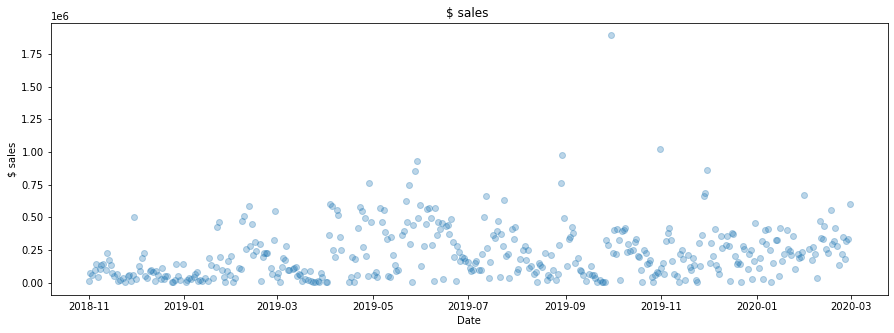

In [17]:
plt.scatter(Sec_invoices_grp.just_date , Sec_invoices_grp.GrossValue , alpha=0.3,cmap='viridis')
plt.xlabel("Date")
plt.ylabel("$ sales")
plt.title("$ sales ")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

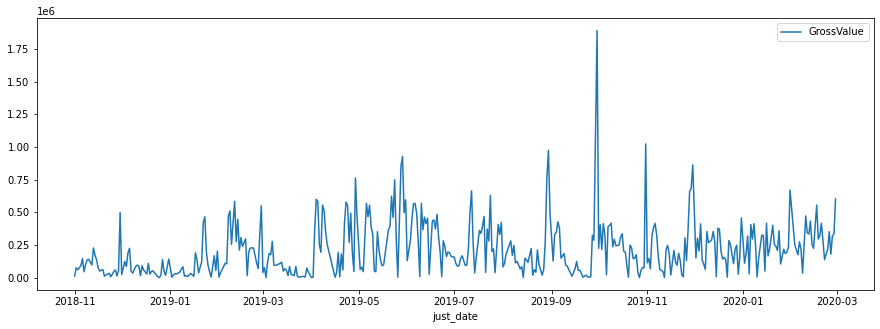

In [18]:
Sec_invoices_grp.plot(kind = 'line', x = 'just_date', y = 'GrossValue')
plt.show()

In [19]:
#fill in the missing dates
drange = pd.date_range(start=Sec_invoices_grp.just_date.min(), end=Sec_invoices_grp.just_date.max())
Sec_invoices_grp = Sec_invoices_grp.set_index('just_date').reindex(drange).rename_axis('just_date').reset_index()

In [20]:
##Add date related colums
Sec_invoices_grp['Year'] = Sec_invoices_grp['just_date'].dt.year
Sec_invoices_grp['Month'] = Sec_invoices_grp['just_date'].dt.month
Sec_invoices_grp['Day'] = Sec_invoices_grp['just_date'].dt.day
Sec_invoices_grp['WeekDay'] = Sec_invoices_grp['just_date'].dt.dayofweek
#Sec_invoices_grp['Hour'] = Sec_invoices_grp['just_date'].dt.hour

In [21]:
Sec_invoices_grp.head()

,just_date,OutletUID,DistributorUID,AgentUID,ProvinceUID,DistrictUID,AreaUID,UnitPrice,GrossValue,Year,Month,Day,WeekDay
0,2018-11-01,2704.0,14.0,155.0,16.0,19.0,382.0,276.3,11052.0,2018,11,1,3
1,2018-11-02,4326.0,22.0,155.0,30.0,32.0,474.0,276.3,75429.9,2018,11,2,4
2,2018-11-03,4693.0,23.0,157.0,30.0,32.0,520.0,276.3,59680.8,2018,11,3,5
3,2018-11-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,11,4,6
4,2018-11-05,4200.0,14.0,155.0,20.0,23.0,520.0,276.3,92007.9,2018,11,5,0


In [22]:
#fill missing value by cosidering weekday
for x in range (0, 7):
    mask = Sec_invoices_grp['WeekDay'] == x

    Out_Mode = Sec_invoices_grp.loc[mask, 'OutletUID'].mode()[0]
    Dis_Mode = Sec_invoices_grp.loc[mask, 'DistributorUID'].mode()[0]
    Agt_Mode = Sec_invoices_grp.loc[mask, 'AgentUID'].mode()[0]
    Pro_Mode = Sec_invoices_grp.loc[mask, 'ProvinceUID'].mode()[0]
    Dist_Mode = Sec_invoices_grp.loc[mask, 'DistrictUID'].mode()[0]
    Ar_Mode = Sec_invoices_grp.loc[mask, 'AreaUID'].mode()[0]
    UP_mean = Sec_invoices_grp.loc[mask, 'UnitPrice'].mean()
    GV_mean = Sec_invoices_grp.loc[mask, 'GrossValue'].mean()

    Sec_invoices_grp['OutletUID'] = Sec_invoices_grp['OutletUID'].mask(mask, Sec_invoices_grp['OutletUID'].fillna(Out_Mode))
    Sec_invoices_grp['DistributorUID'] = Sec_invoices_grp['DistributorUID'].mask(mask, Sec_invoices_grp['DistributorUID'].fillna(Dis_Mode))
    Sec_invoices_grp['AgentUID'] = Sec_invoices_grp['AgentUID'].mask(mask, Sec_invoices_grp['AgentUID'].fillna(Agt_Mode))
    Sec_invoices_grp['ProvinceUID'] = Sec_invoices_grp['ProvinceUID'].mask(mask, Sec_invoices_grp['ProvinceUID'].fillna(Pro_Mode))
    Sec_invoices_grp['DistrictUID'] = Sec_invoices_grp['DistrictUID'].mask(mask, Sec_invoices_grp['DistrictUID'].fillna(Dist_Mode))
    Sec_invoices_grp['AreaUID'] = Sec_invoices_grp['AreaUID'].mask(mask, Sec_invoices_grp['AreaUID'].fillna(Ar_Mode))
    Sec_invoices_grp['UnitPrice'] = Sec_invoices_grp['UnitPrice'].mask(mask, Sec_invoices_grp['UnitPrice'].fillna(UP_mean))
    Sec_invoices_grp['GrossValue'] = Sec_invoices_grp['GrossValue'].mask(mask, Sec_invoices_grp['GrossValue'].fillna(GV_mean))

In [23]:
Sec_invoices_grp.head()

,just_date,OutletUID,DistributorUID,AgentUID,ProvinceUID,DistrictUID,AreaUID,UnitPrice,GrossValue,Year,Month,Day,WeekDay
0,2018-11-01,2704.0,14.0,155.0,16.0,19.0,382.0,276.300000,11052.000000,2018,11,1,3
1,2018-11-02,4326.0,22.0,155.0,30.0,32.0,474.0,276.300000,75429.900000,2018,11,2,4
2,2018-11-03,4693.0,23.0,157.0,30.0,32.0,520.0,276.300000,59680.800000,2018,11,3,5
3,2018-11-04,105.0,14.0,155.0,20.0,21.0,299.0,300.234783,29866.195652,2018,11,4,6
4,2018-11-05,4200.0,14.0,155.0,20.0,23.0,520.0,276.300000,92007.900000,2018,11,5,0


In [24]:
# Covert to date
Sec_invoices_grp["just_date"] = pd.to_datetime(Sec_invoices_grp["just_date"]).dt.date

In [25]:
startdate = pd.to_datetime("2019-11-30").date()

train = Sec_invoices_grp.loc[Sec_invoices_grp['just_date'] <= startdate]
train = train.set_index('just_date')
test = Sec_invoices_grp.loc[Sec_invoices_grp['just_date'] > startdate]
test = test.set_index('just_date')

In [26]:
exogenous_features = ['OutletUID', 'DistributorUID','AgentUID'
                      ,'ProvinceUID','DistrictUID' ,'AreaUID'
                      ,'Year', 'Month' ,'Day','WeekDay'
                      ,'UnitPrice']

In [27]:
from pmdarima import auto_arima
model = auto_arima(train.GrossValue, test='adf',exogenous=train[exogenous_features], trace=True)
results = model.fit(train.GrossValue)
results.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=10604.840, Time=1.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=10643.630, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=10603.616, Time=0.55 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=10613.902, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12609.290, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=10603.027, Time=0.59 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=10604.952, Time=0.66 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=10602.857, Time=0.90 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=10602.725, Time=0.54 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=10603.255, Time=0.93 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=10603.682, Time=0.60 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=10600.730, Time=0.52 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=10611.902, Time=0.70 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=10601.616, Time=0.47 sec
 ARIMA(2,0,1)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  395
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -5371.509
Date:                Thu, 17 Mar 2022   AIC                          10749.017
Time:                        19:18:38   BIC                          10760.954
Sample:                             0   HQIC                         10753.747
                                - 395                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9727      0.016     58.988      0.000       0.940       1.005
ma.L1         -0.7042      0.040    -17.736      0.000      -0.782      -0.626
sigma2      4.004e+10   5.14e-14   7.79e+23      0.000       4e+10       4e+10
===================================================================================
Ljung-Box (L1) (Q):                   6.29   Jarque-Bera (JB):              5986.09
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               4.14   Skew:                             2.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.6e+39. Standard errors may be unstable.
"""

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['GrossValue'],exogenous=train[exogenous_features]
                ,order=(1,0,1),seasonal_order=(0,0,0,0))
results = model.fit(disp=0)
results.summary()

c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             GrossValue   No. Observations:                  395
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -5371.509
Date:                Thu, 17 Mar 2022   AIC                          10749.017
Time:                        19:18:38   BIC                          10760.954
Sample:                    11-01-2018   HQIC                         10753.747
                         - 11-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9727      0.016     58.988      0.000       0.940       1.005
ma.L1         -0.7042      0.040    -17.736      0.000      -0.782      -0.626
sigma2      4.004e+10   5.14e-14   7.79e+23      0.000       4e+10       4e+10
===================================================================================
Ljung-Box (L1) (Q):                   6.29   Jarque-Bera (JB):              5986.09
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               4.14   Skew:                             2.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.6e+39. Standard errors may be unstable.
"""

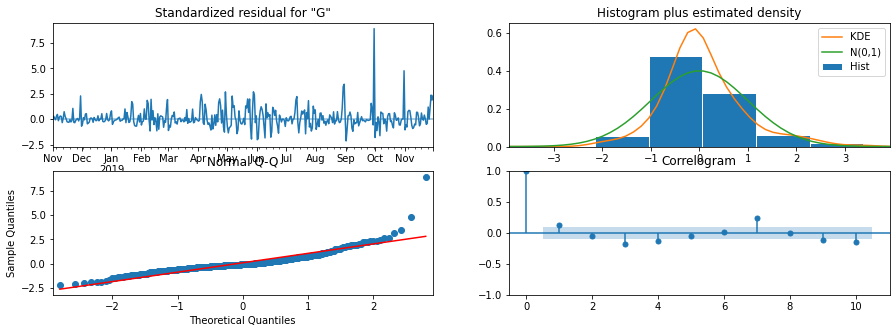

In [29]:
results.plot_diagnostics()
plt.show()

In [30]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test_result = results.predict(start='2019-12-01', end='2020-02-29')
mse = mean_squared_error(test.GrossValue, test_result)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 209932.243136


#### Since this is quiet high value for RMSE the model is not best to predict.

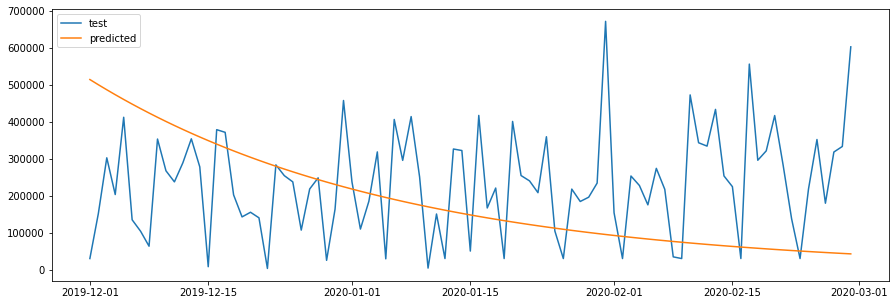

In [31]:
plt.plot(test.GrossValue)
plt.plot(test_result)
plt.legend(['test', 'predicted'])